## project :  Fruits recognition using Deep Learning

In [54]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
BATCH = 32
IMAGE = 300
CHANNELl=3
EPOCHS1=40

In [57]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE,IMAGE),
    batch_size=BATCH
)


Found 1212 files belonging to 5 classes.


### Visualization

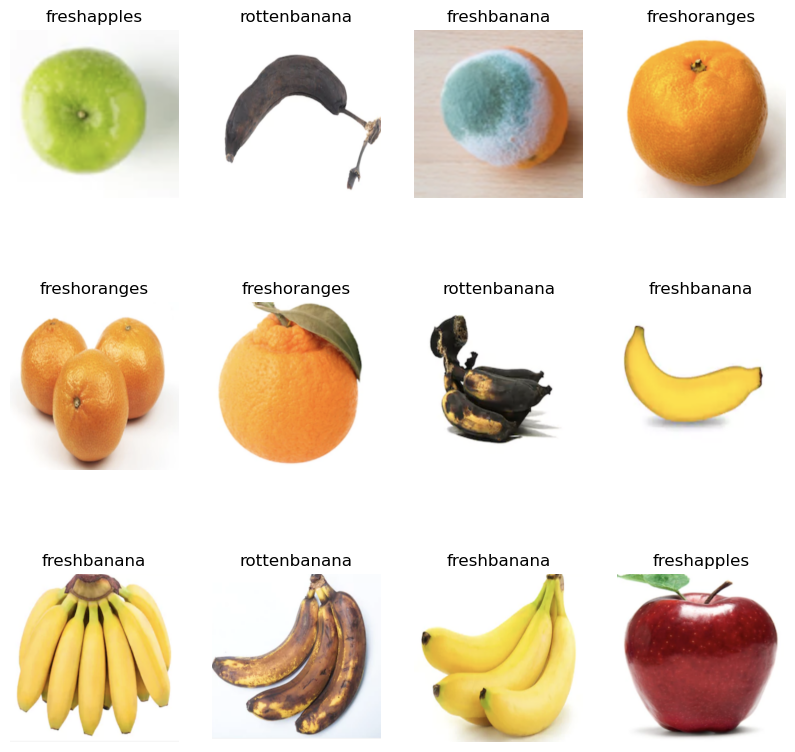

In [6]:

# Get a single batch from the dataset
for images, labels in dataset.take(1):
    # Keep this data for visualization
    images_to_plot = images
    labels_to_plot = labels.numpy()

# Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images_to_plot[i].numpy().astype("uint8"))
    plt.title(classes_name[labels_to_plot[i]])
    plt.axis("off")

In [7]:
def partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1  
    ds1_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) 
    trains_size = int(train_split * ds1_size)
    valid_size = int(val_split * ds1_size)
    trains_ds = ds.take(trains_size)    
    valid_ds = ds.skip(trains_size).take(valid_size)
    tests_ds = ds.skip(trains_size).skip(valid_size)
    return trains_ds, valid_ds, tests_ds

In [8]:
trains_ds, valid_ds, tests_ds = partitions(dataset)
trains_ds = trains_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
tests_ds = tests_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resizes_and_rescales = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE, IMAGE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
RandomRotation: Rotates the image by a factor of the range specified; here it's 20%, which means the image can be rotated between -20% to +20% of 360 degrees.

RandomCrop: Crops the images to the specified height and width. In your case, since you already set IMAGE_SIZE to 300, it will crop to this dimension. Make sure your input images are larger than the crop size to avoid errors or unwanted scaling.

RandomZoom: Applies a random zoom of +/- 20%. It randomly zooms the image in and out slightly, which can help the model generalize across different image sizes.

RandomTranslation (wrapping effect): Moves the image up/down/left/right by 20%, filling the empty pixels with a reflection of the edge pixels. This simulates the effect of image wrapping.

RandomContrast: Adjusts the contrast of the image by a factor of 0.2 which can enhance or mute the intensity of the pixels.

RandomBrightness: Alters the brightness of the image by +/- 20%. This helps the model cope with different lighting conditions.

In [14]:
#new Augmentation
import tensorflow as tf
from tensorflow.keras import layers

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(factor=0.2),  # Rotate by 20% (+/- degrees)
    layers.RandomCrop(height=IMAGE, width=IMAGE),  # Crop images
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),  # Zoom in/out 20%
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='reflect'), # Wrapping
    layers.RandomContrast(factor=0.2),  # Adjusting Contrast for visibility
    layers.RandomBrightness(factor=0.2)  # Adjust Brightness +/- 20%
])

# Applying Data Augmentation to the Training Dataset
trains_ds = trains_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)

### CNN Model

In [15]:
#new CNN
from tensorflow.keras import models, layers

IMAGE = 300
CHANNELl = 3
n_classes = 5  

model = models.Sequential([
    # First, the preprocessing layers
    layers.experimental.preprocessing.Resizing(IMAGE, IMAGE),
    layers.experimental.preprocessing.Rescaling(1./255),
    # First convolution block
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    # Second convolution block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    # Third convolution block
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    # Fourth convolution block
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5), 
    # Flattening the output to feed into a Dense layer
    layers.Flatten(), 
    # Dense Layer
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output Layer
    layers.Dense(n_classes, activation='softmax'),
])

# Print the model summary to check the architecture
model.build(input_shape=(None, IMAGE, IMAGE, CHANNELl))  # `None` can accommodate any batch size


In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 300, 300, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 300, 300, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 150, 150, 32)     

In [18]:
#New compiler
#Compiling the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Ideal for multi-class classification
    metrics=['accuracy']  # Accuracy is a common metric for classification tasks
)

In [19]:
nhistor = model.fit(
    trains_ds,
    batch_size=BATCH,
    validation_data=valid_ds,
    verbose=1,
    epochs1=40,
)

Epoch 1/40
30/30 [==============================] - 262s 8s/step - loss: 1.5074 - accuracy: 0.4655 - val_loss: 6.1075 - val_accuracy: 0.1667
Epoch 2/40
30/30 [==============================] - 257s 8s/step - loss: 0.9897 - accuracy: 0.6423 - val_loss: 6.0605 - val_accuracy: 0.1146
Epoch 3/40
30/30 [==============================] - 247s 8s/step - loss: 1.0180 - accuracy: 0.6402 - val_loss: 2.3237 - val_accuracy: 0.3542
Epoch 4/40
30/30 [==============================] - 822s 28s/step - loss: 1.0150 - accuracy: 0.6506 - val_loss: 1.6638 - val_accuracy: 0.4167
Epoch 5/40
30/30 [==============================] - 250s 8s/step - loss: 0.9550 - accuracy: 0.6831 - val_loss: 3.4359 - val_accuracy: 0.3542
Epoch 6/40
30/30 [==============================] - 248s 8s/step - loss: 0.7869 - accuracy: 0.7270 - val_loss: 2.4510 - val_accuracy: 0.3542
Epoch 7/40
30/30 [==============================] - 255s 8s/step - loss: 0.7755 - accuracy: 0.7113 - val_loss: 2.4983 - val_accuracy: 0.3542
Epoch 8/40
3

In [20]:
score = model.evaluate(tests_ds)
score

5/5 [==============================] - 11s 2s/step - loss: 2.9033 - accuracy: 0.8000


In [27]:
nhistor.nhistor['loss'][:5] # show loss for first 5 epochs

[1.507368564605713,
 0.9896532297134399,
 1.0180124044418335,
 1.0149649381637573,
 0.9550008177757263]

In [28]:
acc = nhistor.nhistor['accuracy']
val_acc = nhistor.nhistor['val_accuracy']

loss = nhistor.nhistor['loss']
val_loss = nhistor.nhistor['val_loss']

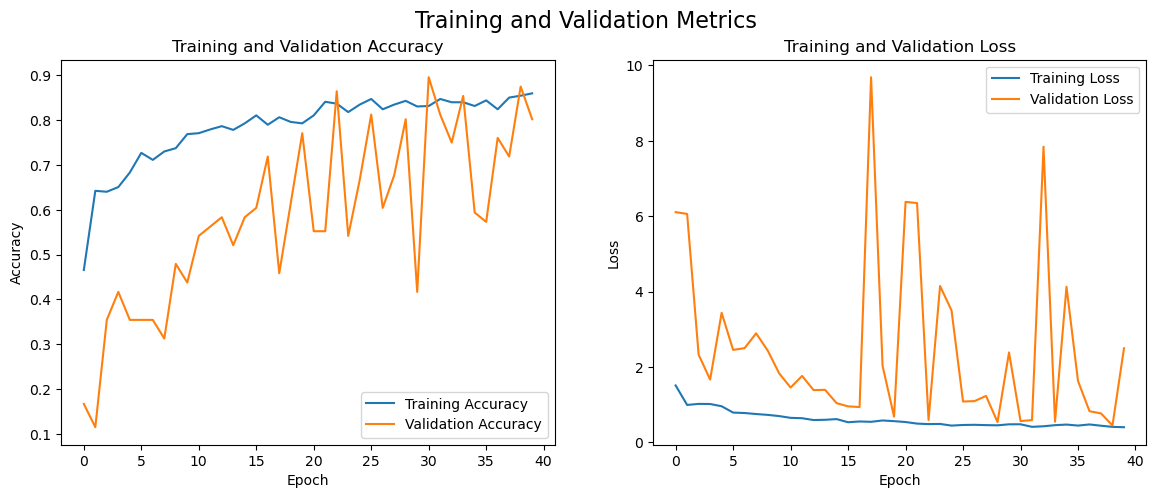

In [30]:
#NEW
import matplotlib.pyplot as plt

# Plotting the Training and Validation Accuracy and Loss Curves
def plot_training_nhistor(nhistor, epochs1):
    acc = nhistor.nhistor['accuracy']
    val_acc = nhistor.nhistor['val_accuracy']
    loss = nhistor.nhistor['loss']
    val_loss = nhistor.nhistor['val_loss']

    epochs_range = range(epochs1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.suptitle('Training and Validation Metrics', fontsize=16)
    plt.show()

# Assuming 'nhistor' is the output from your model training and 'EPOCHS' is defined as before
plot_training_nhistor(nhistor, EPOCHS1)

1/1 [==============================] - 0s 110ms/step


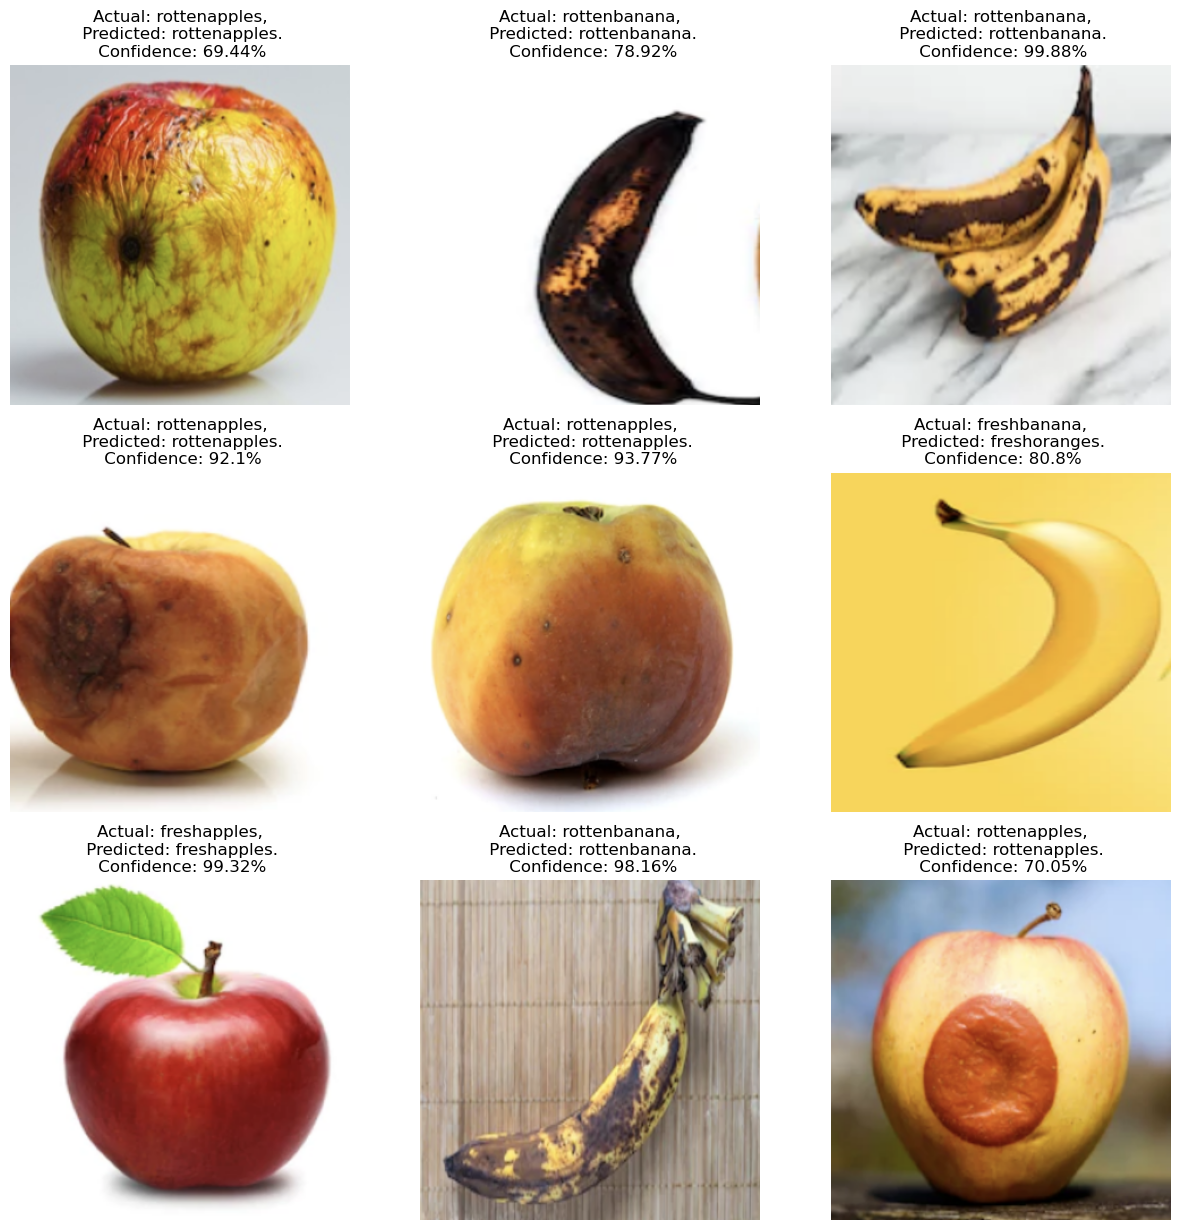

In [36]:
#New Plot 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict(model, imge):
    # Convert the image to an array and add a batch dimension
    imge_array = tf.keras.preprocessing.image.img_to_array(imge)
    imge_array = tf.expand_dims(imge_array, 0)

    # Generate predictions for the input image
    npredictions = model.predict(imge_array)

    # Decode the predictions into a class name and confidence level
    npredicted_class = class_names[np.argmax(npredictions[0])]
    confidencee = round(100 * np.max(npredictions[0]), 2)
    return npredicted_class, confidencee

# Plotting the images with predictions
plt.figure(figsize=(15, 15))
for images, labels in tests_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Predict using the single image
        npredicted_class, confidencee = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {npredicted_class}.\n Confidence: {confidencee}%")
        plt.axis("off")

plt.show()

In [ ]:
##NEW MODEL
Key Features of this Model:
MobileNetV2 Base: This model is lightweight and efficient for mobile and edge devices, making it ideal for applications where model size and inference speed are crucial.
Transfer Learning: By using a pre-trained model, you can leverage learned features from a vast and diverse dataset (ImageNet), enhancing performance even with limited training data.
Fine-Tuning: Although the base layers are frozen during initial training, you could unfreeze some of the top layers and continue training for a few more epochs to potentially boost performance further.
This approach should provide robust performance given the complexity of fruit image classification.

Found 1212 files belonging to 5 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/20
30/30 [==============================] - 54s 1s/step - loss: 0.4433 - accuracy: 0.8494 - val_loss: 0.0760 - val_accuracy: 0.9896
Epoch 2/20
30/30 [==============================] - 37s 1s/step - loss: 0.0921 - accuracy: 0.9738 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 3/20
30/30 [==============================] - 37s 1s/step - loss: 0.0490 - accuracy: 0.9874 - val_loss: 0.0443 - val_accuracy: 0.9792
Epoch 4/20
30/30 [==============================] - 37s 1s/step - loss: 0.0323 - accuracy: 0.9937 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 5/20
30/30 [==============================] - 40s 1s/step - loss: 0.0238 - accuracy: 0.9927 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 6/20
30/30 [==============================] - 38s 1s/step - loss: 0.0140 - accuracy: 0.9979 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 7/20
30/30 [==============================] - 38s 

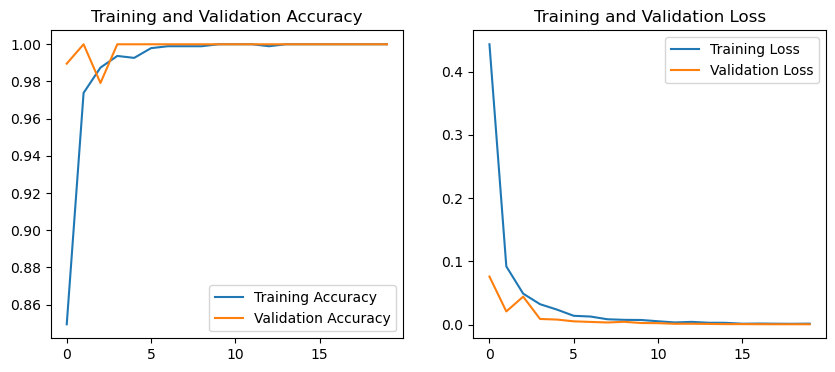

In [36]:
#Try Another Model
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Constants
BATCH = 32
IMAGE = (224, 224)  # MobileNetV2 expects images of size 224x224
CHANNELl = 3
EPOCHS1 = 20

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=IMAGE,
    batch_size=BATCH
)
classes_name = dataset.classes_name

# Splitting the dataset
def partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    ds1_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    trains_size = int(train_split * ds1_size)
    valid_size = int(val_split * ds1_size)
    trains_ds = ds.take(trains_size)
    valid_ds = ds.skip(trains_size).take(valid_size)
    tests_ds = ds.skip(trains_size + valid_size)
    return trains_ds, valid_ds, tests_ds

trains_ds, valid_ds, tests_ds = partitions(dataset)

# Apply caching, shuffling, and prefetching
trains_ds = trains_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
tests_ds = tests_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data preprocessing for MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Load MobileNetV2 model pre-trained on ImageNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Create the model
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),  # MobileNetV2 expects inputs in [-1, 1]
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(classes_name), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
nhistor = model.fit(
    trains_ds,
    validation_data=valid_ds,
    epochs=EPOCHS1,
    verbose=1
)

# Evaluate the model on the test dataset
scores = model.evaluate(tests_ds)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(nhistor.nhistor['accuracy'], label='Training Accuracy')
plt.plot(nhistor.nhistor['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nhistor.nhistor['loss'], label='Training Loss')
plt.plot(nhistor.nhistor['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
Highlights of This Model:
Batch Normalization: Improves training stability by normalizing the input layer by adjusting and scaling activations.
Dropout: Reduces overfitting by randomly setting a fraction of input units to 0 at each update during training time.
Convolutional Layers: Different sizes of convolutional filters (32, 64, 128) are used to extract various levels of features from the images.
Pooling Layers: Reduce the spatial dimensions of the output from the convolutional layers to decrease the computational load, memory usage, and number of parameters.
This model is designed to be simple and efficient, making it suitable for environments with limited computational resources or for applications requiring quick iterations or experiments.

Found 1212 files belonging to 5 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normal

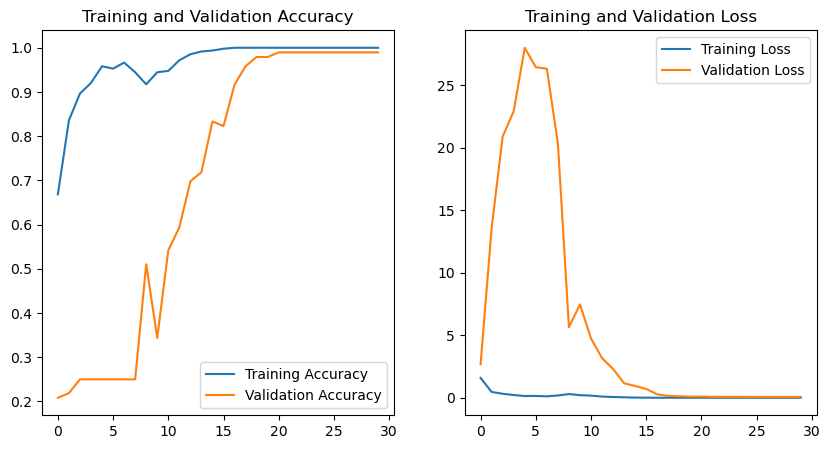

In [37]:
#Try Another Model 2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Constants
BATCH = 32
IMAGE = (128, 128)  # Using a smaller image size for efficiency
CHANNELl = 3
EPOCHS1 = 30

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=IMAGE,
    batch_size=BATCH
)
classes_name = dataset.classes_name

# Function to split the dataset
def partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    ds1_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    trains_size = int(train_split * ds1_size)
    valid_size = int(val_split * ds1_size)
    trains_ds = ds.take(trains_size)
    valid_ds = ds.skip(trains_size).take(valid_size)
    tests_ds = ds.skip(trains_size + valid_size)
    return trains_ds, valid_ds, tests_ds

trains_ds, valid_ds, tests_ds = partitions(dataset)

# Apply caching, shuffling, and prefetching
trains_ds = trains_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
tests_ds = tests_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the model
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE[0], IMAGE[1], 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes_name), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
nhistor = model.fit(
    trains_ds,
    validation_data=valid_ds,
    epochs=EPOCHS1,
    verbose=1
)

# Evaluate the model on the test dataset
scores = model.evaluate(tests_ds)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(nhistor.nhistor['accuracy'], label='Training Accuracy')
plt.plot(nhistor.nhistor['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nhistor.nhistor['loss'], label='Training Loss')
plt.plot(nhistor.nhistor['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [38]:
scores = model.evaluate(tests_ds)
scores

5/5 [==============================] - 1s 141ms/step - loss: 0.2607 - accuracy: 0.9812


[0.26074686646461487, 0.981249988079071]

1/1 [==============================] - 0s 50ms/step


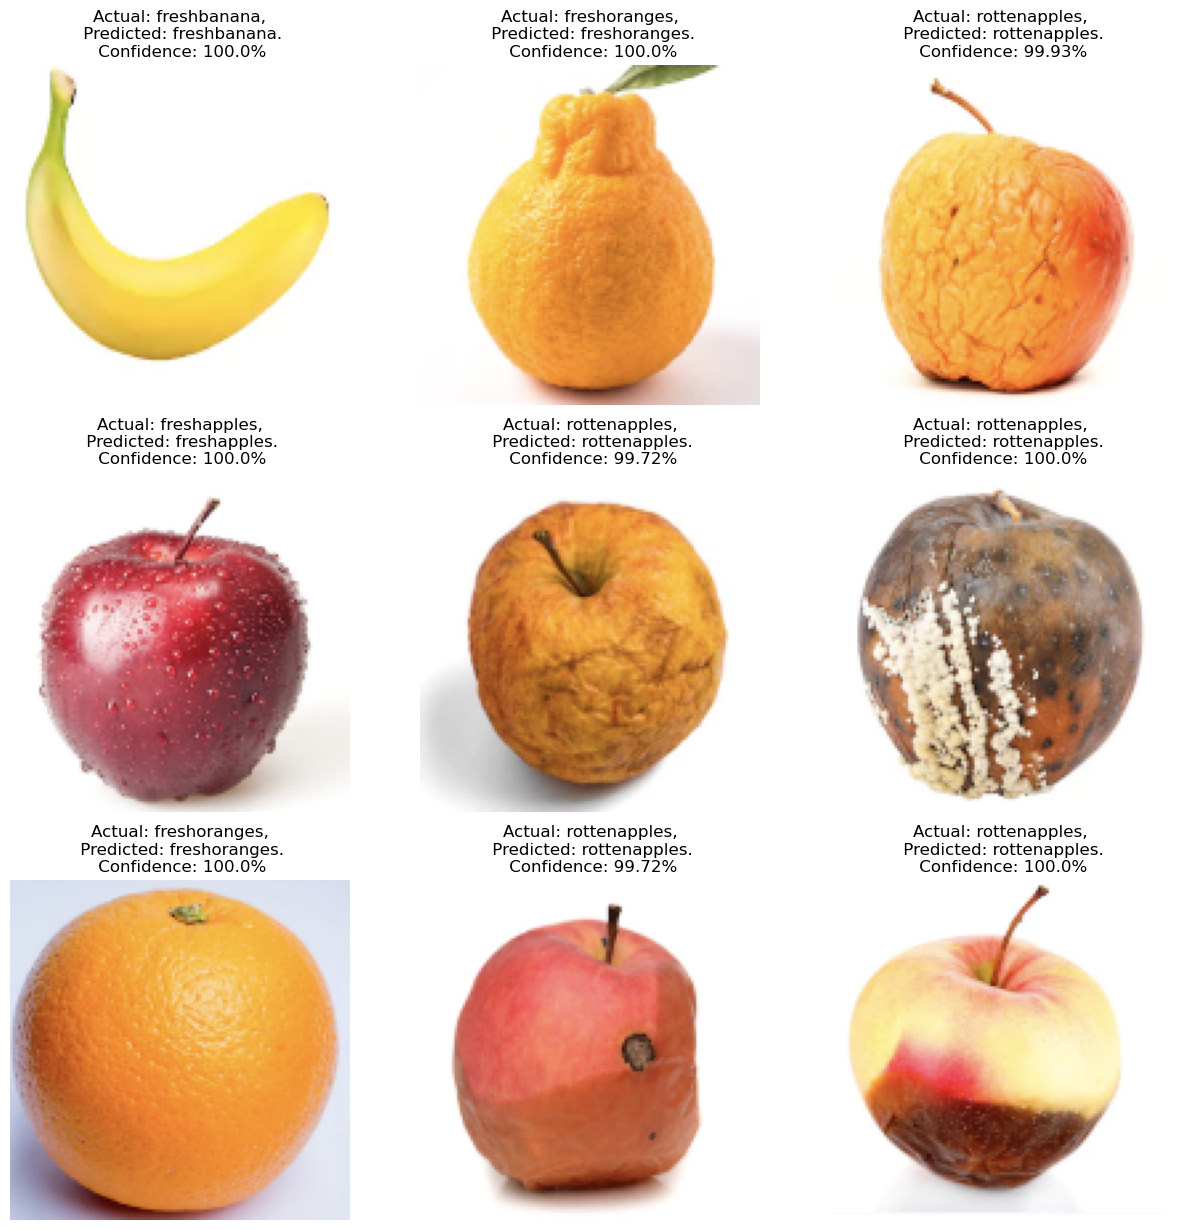

In [40]:
def predict(model, imge):
    imge_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    imge_array = tf.expand_dims(imge_array, 0)

    npredictions = model.predict(imge_array)

    npredicted_class = classes_name[np.argmax(npredictions[0])]
    confidencee = round(100 * (np.max(npredictions[0])), 2)
    return npredicted_class, confidencee

plt.figure(figsize=(15, 15))
for images, labels in tests_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        npredicted_class, confidencee = predict(model, images[i].numpy())
        actual_class = classes_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {npredicted_class}.\n Confidence: {confidencee}%")
        
        plt.axis("off")

Found 1212 files belonging to 5 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 separable_conv2d (Separabl  (None, 61, 61, 64)        2400      
 eConv2D)                                                        
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
             

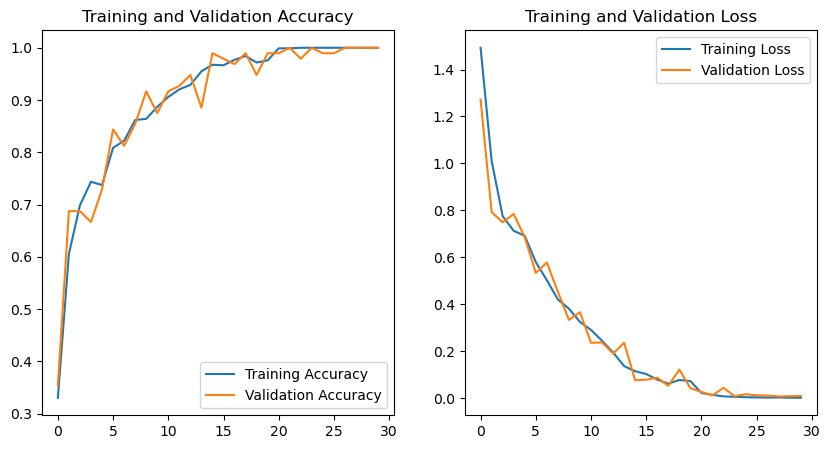

In [51]:
#Try Another Model 3
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Constants
BATCH = 32
IMAGE = (128, 128)
CHANNELl = 3
EPOCHS1 = 30
DATA_DIR = "train"  # Adjust this if your dataset directory is different

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    seed=123,
    shuffle=True,
    image_size=IMAGE,
    batch_size=BATCH
)
classes_name = dataset.classes_name

# Splitting the dataset into training, validation, and test sets
def partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    ds1_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    trains_size = int(train_split * ds1_size)
    valid_size = int(val_split * ds1_size)
    trains_ds = ds.take(trains_size)
    valid_ds = ds.skip(trains_size).take(valid_size)
    tests_ds = ds.skip(trains_size + valid_size)
    return trains_ds, valid_ds, tests_ds

trains_ds, valid_ds, tests_ds = partitions(dataset)

# Applying cache, shuffle, and prefetch operations to improve performance
trains_ds = trains_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
tests_ds = tests_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model building using depthwise separable convolutions
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE[0], IMAGE[1], 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.SeparableConv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.SeparableConv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes_name), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
nhistor = model.fit(
    trains_ds,
    validation_data=valid_ds,
    epochs=EPOCHS1,
    verbose=1
)

# Evaluate the model on the test dataset
scores = model.evaluate(tests_ds)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(nhistor.nhistor['accuracy'], label='Training Accuracy')
plt.plot(nhistor.nhistor['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nhistor.nhistor['loss'], label='Training Loss')
plt.plot(nhistor.nhistor['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()